# Import

In [1]:
import pickle

# math and dataframes
import pandas as pd
import numpy as np

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier

# Pipeline and Evaluation
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, RandomizedSearchCV 
from sklearn.tree import plot_tree
from imblearn.pipeline import make_pipeline

# Undersampling 
# Note: undersampling was used in at least 1 paper predicting popularity (Gao 2021)
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# jupyter notebook full-width display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# pandas formatting
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import seaborn as sns
sns.set_theme()

In [2]:
df_10M = pd.read_pickle('df_10M_clustered.pickle')
X_all = pd.read_pickle('X_clustered.pickle')

# Create Datasets for Prediction

In [3]:
y_column = 'in_B100'
X_columns = [
    'mode', 'acousticness', 'danceability', 'duration_ms', 'energy',
    'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence'
]
genre_columns = [
    'is_Adult_Standard', 'is_Rock', 'is_R&B', 'is_Country', 'is_Pop',
    'is_Rap', 'is_Alternative', 'is_EDM', 'is_Metal'
]
cluster_columns = ['cluster', 'cluster2']
other_columns = ['key', 'time_signature', 'genre', 'release_date']


In [4]:
# create a dict with all 'name': (X, y) key match pairs
clusters = {}

# entire predictive dataset
clusters['All'] = (X_all[X_columns], X_all[y_column])

# add genres
for genre in genre_columns:
    title = genre[3:]
    clusters[title] = (X_all[X_all[genre]][X_columns], X_all[X_all[genre]][y_column])
    
# add clusters
for n in sorted(X_all['cluster'].unique()):
    title = genre[3:]
    clusters['cluster1_' + str(n)] = (X_all[X_all['cluster'] == n][X_columns], X_all[X_all['cluster'] == n][y_column])
    
for n in sorted(X_all['cluster2'].unique()):
    title = genre[3:]
    clusters['cluster2_' + str(n)] = (X_all[X_all['cluster2'] == n][X_columns], X_all[X_all['cluster2'] == n][y_column])
    
# OPTIONAL IF TIME PERMITS: consider adding decades or eras of music

In [5]:
# main non-clustered predictive dataset (all data)
X, y = clusters['All']

In [6]:
clusters.keys()

dict_keys(['All', 'Adult_Standard', 'Rock', 'R&B', 'Country', 'Pop', 'Rap', 'Alternative', 'EDM', 'Metal', 'cluster1_0', 'cluster1_1', 'cluster1_2', 'cluster1_3', 'cluster2_0', 'cluster2_1', 'cluster2_2', 'cluster2_3', 'cluster2_4', 'cluster2_5', 'cluster2_6', 'cluster2_7', 'cluster2_8', 'cluster2_9'])

# Compare Algorithms
### Check Calculation Speeds

In [8]:
ML_algorithms = [
    LogisticRegression,
    DecisionTreeClassifier,
    KNeighborsClassifier,
    RandomForestClassifier,
    AdaBoostClassifier
]

In [9]:
# these are slow, even the simlest models
# let's see how long they take with a small and medium dataset
# then we can estimate how long each algorithm will take to run

small = X_all.sample(10_000)
y_small = small[y_column]
X_small = small[X_columns]

medium = X_all.sample(100_000)
y_medium = medium[y_column]
X_medium = medium[X_columns]

large = X_all.sample(1_000_000)
y_large = large[y_column]
X_large = large[X_columns]

In [10]:
def ml_time(X, y, ml_n):
    """testing how long each algorithm takes"""
    grid = GridSearchCV(
        estimator=ML_algorithms[ml_n](),
        param_grid={},
        cv=5
    )
    %time grid.fit(X, y)

In [11]:
# small datasets
for i in range(len(ML_algorithms)):
    print(str(ML_algorithms[i])[:-2].split('.')[-1], end=': ')
    ml_time(X_small, y_small, i)

LogisticRegression: Wall time: 195 ms
DecisionTreeClassifier: Wall time: 212 ms
KNeighborsClassifier: Wall time: 622 ms
RandomForestClassifier: Wall time: 3.55 s
AdaBoostClassifier: Wall time: 2.3 s


In [12]:
# medium datasets
for i in range(len(ML_algorithms)):
    print(str(ML_algorithms[i])[:-2].split('.')[-1], end=': ')
    ml_time(X_medium, y_medium, i)

LogisticRegression: Wall time: 962 ms
DecisionTreeClassifier: Wall time: 3.92 s
KNeighborsClassifier: Wall time: 21.7 s
RandomForestClassifier: Wall time: 1min 7s
AdaBoostClassifier: Wall time: 21.4 s


In [13]:
# large datasets
for i in range(len(ML_algorithms)):
    print(str(ML_algorithms[i])[:-2].split('.')[-1], end=': ')
    ml_time(X_large, y_large, i)

LogisticRegression: Wall time: 14.8 s
DecisionTreeClassifier: Wall time: 1min
KNeighborsClassifier: Wall time: 17min 37s
RandomForestClassifier: Wall time: 25min 59s
AdaBoostClassifier: Wall time: 5min 59s


Time Complexity Notes:
* Naive Bayes: O(n*d)
* Logistic Regression: O(n*d)
* Decision Tree: O(n*log(n))
* SVC: O(n^2)
    * Note from medium.com: "if n is large, avoid using SVM."
* Random Forest: O(n*log(n)*k)
    * i assume other boosted trees are similar
    
    
REFERENCE:
https://medium.com/analytics-vidhya/time-complexity-of-ml-models-4ec39fad2770

* based on the above times, it will take about this long to calculate without resampling:
    * LogisticRegression: 1 minute
    * DecisionTreeClassifier: Wall time: 15 minutes
    * KNN: Wall time: 9 hours
    * RandomForestClassifier: Wall time: 7 hours
    * AdaBoostClassifier: Wall time: 58 minutes
    * GradientBoostingClassifier: Wall time: 4 hours (dropped from current version of tests)
    
Note: could take less time if undersampled

### let's try logistic regression and decision tree to see if we're right

In [18]:
%%time
# test logistic regression

grid = GridSearchCV(
    estimator=ML_algorithms[0](),
    param_grid={},
    cv=5
)
grid.fit(X, y)

grid.cv_results_

Wall time: 2min 4s


{'mean_fit_time': array([18.24480934]),
 'std_fit_time': array([2.34020124]),
 'mean_score_time': array([0.8958056]),
 'std_score_time': array([0.00415563]),
 'params': [{}],
 'split0_test_score': array([0.99759508]),
 'split1_test_score': array([0.99759508]),
 'split2_test_score': array([0.99759508]),
 'split3_test_score': array([0.99759508]),
 'split4_test_score': array([0.99759564]),
 'mean_test_score': array([0.99759519]),
 'std_test_score': array([2.26014337e-07]),
 'rank_test_score': array([1])}

In [19]:
# almost 100% accurate by predicting no songs are hits
# need to deal with unbalanced data, but for now, it looks like it's working
1 - sum(y) / y.shape[0]

0.997595188519254

In [20]:
%%time
# check decision tree, different method, just the score
cross_val_score(ML_algorithms[1](), X, y, cv=5, scoring='accuracy').mean()

Wall time: 13min 25s


0.9943485966896315

# Improve Speed and Results
(using Logistic Regression for the tests)

### UNDERSAMPLING

https://imbalanced-learn.org/stable/under_sampling.html

### Also STRATIFIED CROSSVALIDATION 
https://scikit-learn.org/stable/modules/cross_validation.html

MSE: 1.00   stdev Error: 0.00



C:\Users\Kevin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Kevin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Kevin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       False       1.00      1.00      1.00   8806490
        True       0.00      0.00      0.00     21229

    accuracy                           1.00   8827719
   macro avg       0.50      0.50      0.50   8827719
weighted avg       1.00      1.00      1.00   8827719



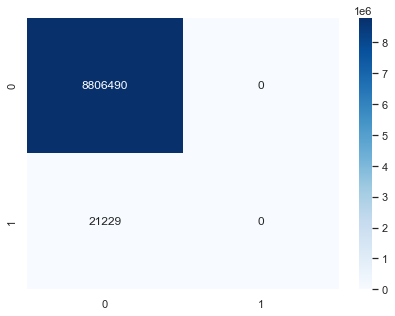

Wall time: 3min 9s


In [45]:
%%time
# default method

# stratified sampling
cv = StratifiedKFold(n_splits=5, shuffle=True)
lr_model = LogisticRegression()
scores = cross_val_score(lr_model, X, y, cv=cv, n_jobs=-1)

# print results
print(f'MSE: {np.mean(scores):.2f}   stdev Error: {np.std(scores):.2f}\n')

y_pred = cross_val_predict(lr_model, X, y, cv=cv)
print(classification_report(y, y_pred))

plt.subplots(figsize=(7, 5))
sns.heatmap(confusion_matrix(y, y_pred), cmap='Blues', annot=True, fmt='.0f')
plt.show()

MSE: 0.69   stdev Error: 0.01

              precision    recall  f1-score   support

       False       0.74      0.58      0.65     21229
        True       0.65      0.80      0.72     21229

    accuracy                           0.69     42458
   macro avg       0.70      0.69      0.69     42458
weighted avg       0.70      0.69      0.69     42458



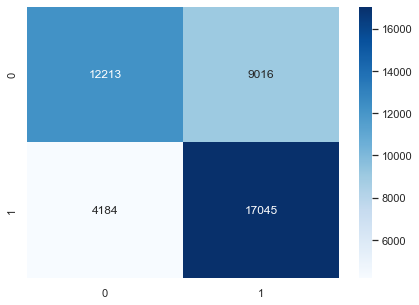

Wall time: 2.75 s


In [44]:
%%time
# undersample method
undersample = RandomUnderSampler()
Xu, yu = undersample.fit_resample(X, y)

# stratified sampling
cv = StratifiedKFold(n_splits=5, shuffle=True)
lr_model = LogisticRegression()

# calculate and print results
scores = cross_val_score(lr_model, Xu, yu, cv=cv, n_jobs=-1)
print(f'MSE: {np.mean(scores):.2f}   stdev Error: {np.std(scores):.2f}\n')

y_pred = cross_val_predict(lr_model, Xu, yu, cv=cv)
print(classification_report(yu, y_pred))

plt.subplots(figsize=(7, 5))
sns.heatmap(confusion_matrix(yu, y_pred), cmap='Blues', annot=True, fmt='.0f')
plt.show()

MSE: 0.57   stdev Error: 0.00

              precision    recall  f1-score   support

       False       1.00      0.57      0.72   8806490
        True       0.00      0.80      0.01     21229

    accuracy                           0.57   8827719
   macro avg       0.50      0.69      0.37   8827719
weighted avg       1.00      0.57      0.72   8827719



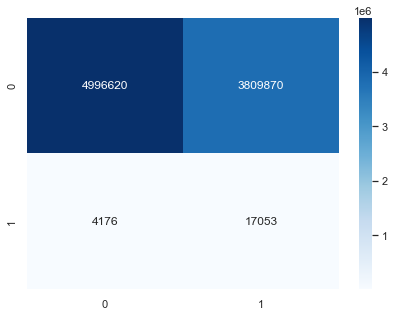

Wall time: 2min 44s


In [46]:
%%time
# balanced class weights

# stratified sampling
cv = StratifiedKFold(n_splits=5, shuffle=True)
lr_model = LogisticRegression(class_weight='balanced')

# calculate and print results
scores = cross_val_score(lr_model, X, y, cv=cv, n_jobs=-1)
print(f'MSE: {np.mean(scores):.2f}   stdev Error: {np.std(scores):.2f}\n')

y_pred = cross_val_predict(lr_model, X, y, cv=cv)
print(classification_report(y, y_pred))

plt.subplots(figsize=(7, 5))
sns.heatmap(confusion_matrix(y, y_pred), cmap='Blues', annot=True, fmt='.0f')
plt.show()

MSE: 0.69   stdev Error: 0.00

              precision    recall  f1-score   support

       False       0.74      0.57      0.64   8806490
        True       0.65      0.80      0.72   8806490

    accuracy                           0.69  17612980
   macro avg       0.70      0.69      0.68  17612980
weighted avg       0.70      0.69      0.68  17612980



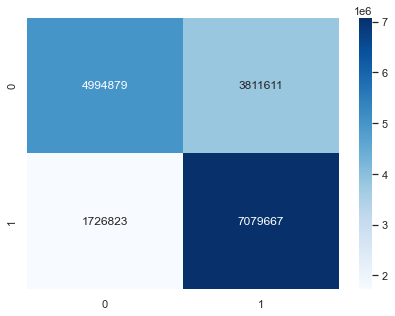

Wall time: 4min 39s


In [47]:
%%time
# oversample method
oversample = RandomOverSampler()
Xo, yo = oversample.fit_resample(X, y)

# stratified sampling
cv = StratifiedKFold(n_splits=5, shuffle=True)
lr_model = LogisticRegression()

# calculate and print results
scores = cross_val_score(lr_model, Xo, yo, cv=cv, n_jobs=-1)
print(f'MSE: {np.mean(scores):.2f}   stdev Error: {np.std(scores):.2f}\n')

y_pred = cross_val_predict(lr_model, Xo, yo, cv=cv)
print(classification_report(yo, y_pred))

plt.subplots(figsize=(7, 5))
sns.heatmap(confusion_matrix(yo, y_pred), cmap='Blues', annot=True, fmt='.0f')
plt.show()


#### looks like undersampling is almost as good as oversampling, and WAY faster
<br>
<div>
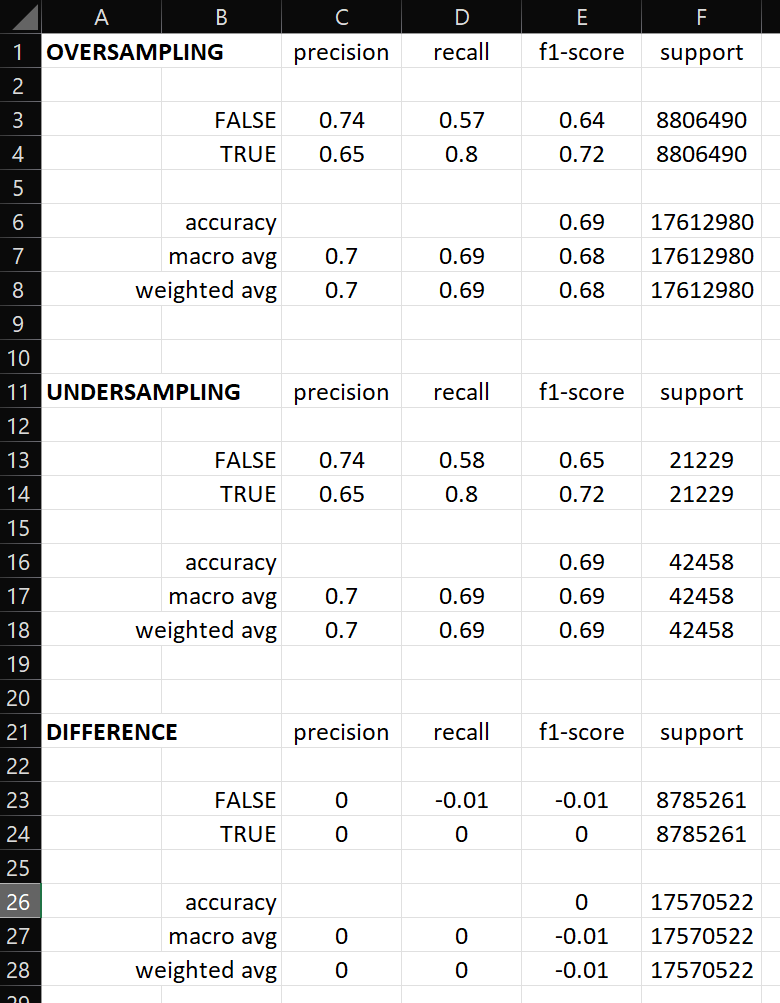
</div>

# Compare Algorithms
### Make Predictions Using Default ML Settings

In [14]:
cluster_keys = [
    'All', 
    'Adult_Standard', 'Rock', 'R&B', 'Country', 'Pop', 'Rap', 'Alternative', 'EDM', 'Metal', 
    'cluster1_0', 'cluster1_1', 'cluster1_2', 'cluster1_3', 
    'cluster2_0', 'cluster2_1', 'cluster2_2', 'cluster2_3', 'cluster2_4', 
    'cluster2_5', 'cluster2_6', 'cluster2_7', 'cluster2_8', 'cluster2_9'
]

ML_algorithms = [
    LogisticRegression,
    DecisionTreeClassifier,
    KNeighborsClassifier,
    RandomForestClassifier,
    AdaBoostClassifier
]

------------------------------------------------------------------------------------
LogisticRegression All

              precision    recall  f1-score   support

       False       1.00      0.57      0.72   8806490
        True       0.00      0.80      0.01     21229

    accuracy                           0.57   8827719
   macro avg       0.50      0.68      0.37   8827719
weighted avg       1.00      0.57      0.72   8827719



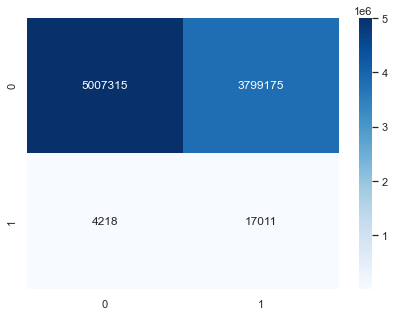

------------------------------------------------------------------------------------
LogisticRegression Adult_Standard

              precision    recall  f1-score   support

       False       0.99      0.68      0.81    205182
        True       0.04      0.75      0.08      3678

    accuracy                           0.68    208860
   macro avg       0.52      0.71      0.44    208860
weighted avg       0.98      0.68      0.80    208860



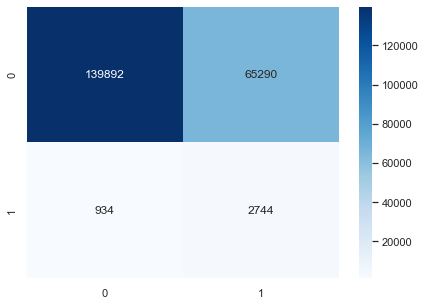

------------------------------------------------------------------------------------
LogisticRegression Rock

              precision    recall  f1-score   support

       False       1.00      0.56      0.72    650866
        True       0.02      0.75      0.03      6311

    accuracy                           0.56    657177
   macro avg       0.51      0.65      0.37    657177
weighted avg       0.99      0.56      0.71    657177



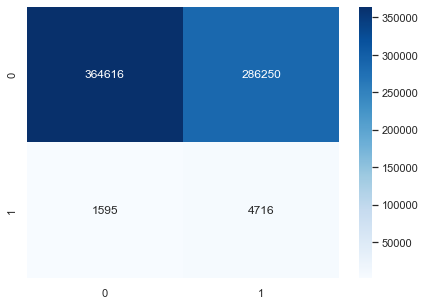

------------------------------------------------------------------------------------
LogisticRegression R&B

              precision    recall  f1-score   support

       False       0.99      0.58      0.73    133613
        True       0.04      0.75      0.07      2965

    accuracy                           0.58    136578
   macro avg       0.51      0.66      0.40    136578
weighted avg       0.97      0.58      0.71    136578



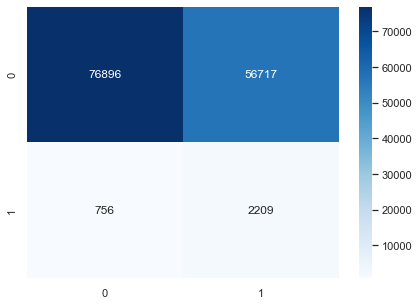

------------------------------------------------------------------------------------
LogisticRegression Country

              precision    recall  f1-score   support

       False       1.00      0.65      0.79    267768
        True       0.02      0.75      0.04      2448

    accuracy                           0.66    270216
   macro avg       0.51      0.70      0.41    270216
weighted avg       0.99      0.66      0.78    270216



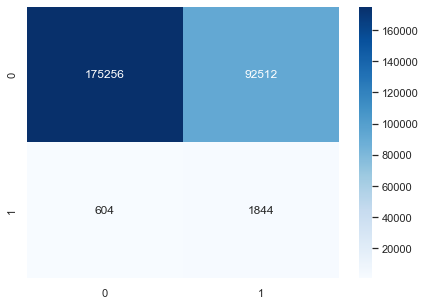

------------------------------------------------------------------------------------
LogisticRegression Pop

              precision    recall  f1-score   support

       False       1.00      0.52      0.68    536222
        True       0.01      0.70      0.02      3904

    accuracy                           0.52    540126
   macro avg       0.50      0.61      0.35    540126
weighted avg       0.99      0.52      0.68    540126



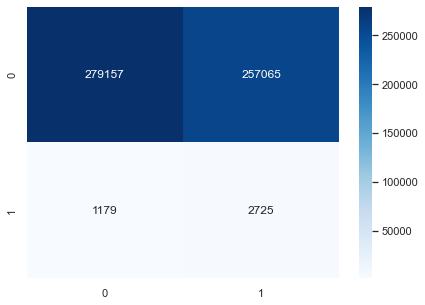

------------------------------------------------------------------------------------
LogisticRegression Rap

              precision    recall  f1-score   support

       False       1.00      0.60      0.75    413914
        True       0.01      0.68      0.02      2084

    accuracy                           0.60    415998
   macro avg       0.50      0.64      0.38    415998
weighted avg       0.99      0.60      0.74    415998



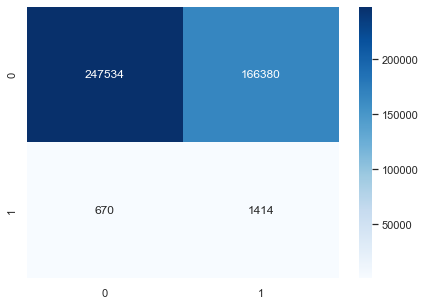

------------------------------------------------------------------------------------
LogisticRegression Alternative

              precision    recall  f1-score   support

       False       1.00      0.61      0.76     84773
        True       0.00      0.84      0.01       177

    accuracy                           0.61     84950
   macro avg       0.50      0.72      0.38     84950
weighted avg       1.00      0.61      0.75     84950



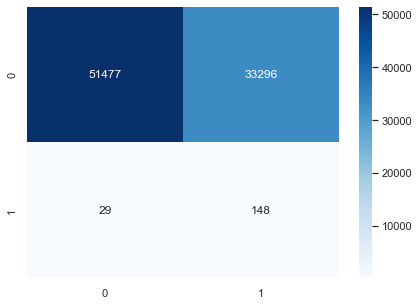

------------------------------------------------------------------------------------
LogisticRegression EDM

              precision    recall  f1-score   support

       False       1.00      0.73      0.84    249494
        True       0.00      0.82      0.00       103

    accuracy                           0.73    249597
   macro avg       0.50      0.77      0.42    249597
weighted avg       1.00      0.73      0.84    249597



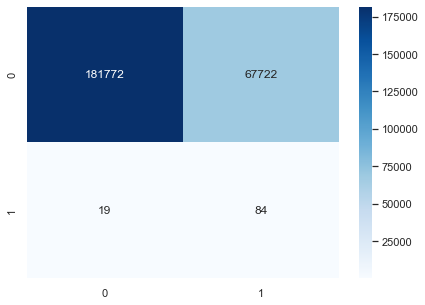

------------------------------------------------------------------------------------
LogisticRegression Metal

              precision    recall  f1-score   support

       False       1.00      0.67      0.80    245257
        True       0.00      0.91      0.00       142

    accuracy                           0.67    245399
   macro avg       0.50      0.79      0.40    245399
weighted avg       1.00      0.67      0.80    245399



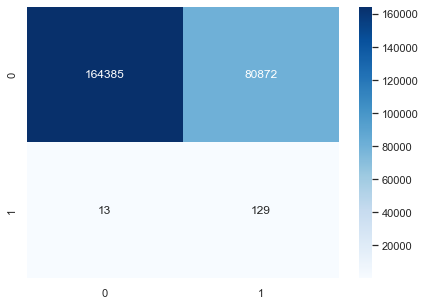

------------------------------------------------------------------------------------
LogisticRegression cluster1_0

              precision    recall  f1-score   support

       False       1.00      0.70      0.83   1233434
        True       0.00      0.74      0.00       184

    accuracy                           0.70   1233618
   macro avg       0.50      0.72      0.41   1233618
weighted avg       1.00      0.70      0.83   1233618



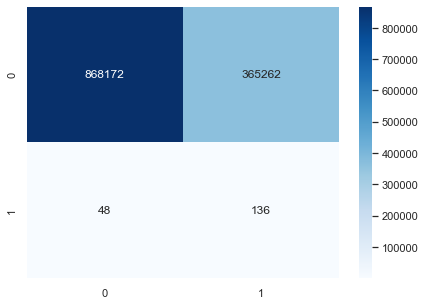

------------------------------------------------------------------------------------
LogisticRegression cluster1_1

              precision    recall  f1-score   support

       False       1.00      0.56      0.71   3963531
        True       0.01      0.66      0.01     14659

    accuracy                           0.56   3978190
   macro avg       0.50      0.61      0.36   3978190
weighted avg       0.99      0.56      0.71   3978190



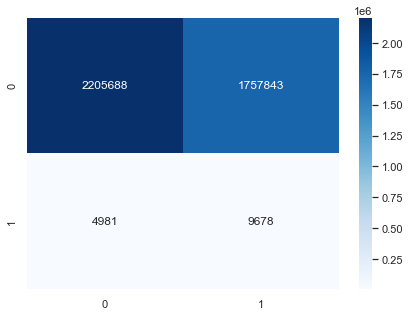

------------------------------------------------------------------------------------
LogisticRegression cluster1_2

              precision    recall  f1-score   support

       False       1.00      0.65      0.78   2298937
        True       0.01      0.71      0.01      5844

    accuracy                           0.65   2304781
   macro avg       0.50      0.68      0.40   2304781
weighted avg       1.00      0.65      0.78   2304781



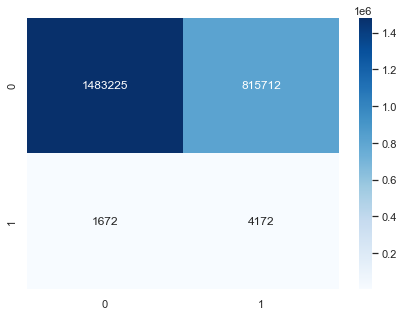

------------------------------------------------------------------------------------
LogisticRegression cluster1_3

              precision    recall  f1-score   support

       False       1.00      0.72      0.84   1310588
        True       0.00      0.77      0.00       542

    accuracy                           0.72   1311130
   macro avg       0.50      0.75      0.42   1311130
weighted avg       1.00      0.72      0.84   1311130



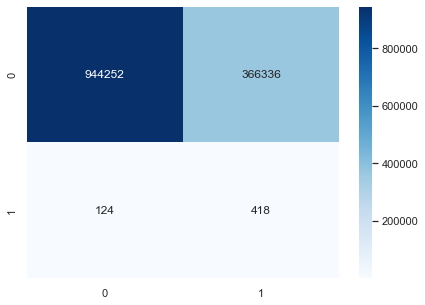

------------------------------------------------------------------------------------
LogisticRegression cluster2_0

              precision    recall  f1-score   support

       False       1.00      0.61      0.76    993405
        True       0.00      0.72      0.01      2156

    accuracy                           0.61    995561
   macro avg       0.50      0.67      0.38    995561
weighted avg       1.00      0.61      0.76    995561



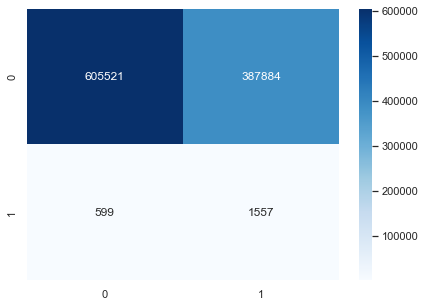

------------------------------------------------------------------------------------
LogisticRegression cluster2_1

              precision    recall  f1-score   support

       False       1.00      0.63      0.77   1083536
        True       0.01      0.74      0.01      3443

    accuracy                           0.63   1086979
   macro avg       0.50      0.69      0.39   1086979
weighted avg       1.00      0.63      0.77   1086979



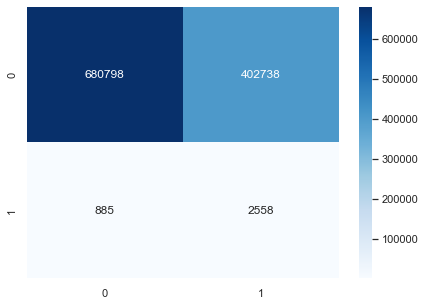

------------------------------------------------------------------------------------
LogisticRegression cluster2_2

              precision    recall  f1-score   support

       False       1.00      0.70      0.82    819369
        True       0.00      0.77      0.00        56

    accuracy                           0.70    819425
   macro avg       0.50      0.73      0.41    819425
weighted avg       1.00      0.70      0.82    819425



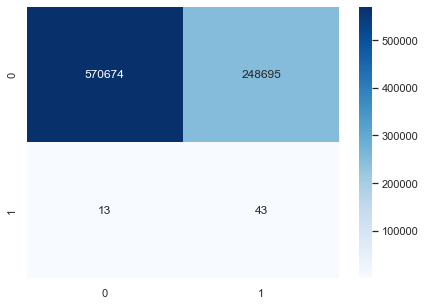

------------------------------------------------------------------------------------
LogisticRegression cluster2_3

              precision    recall  f1-score   support

       False       1.00      0.69      0.81    755260
        True       0.00      0.69      0.00       101

    accuracy                           0.69    755361
   macro avg       0.50      0.69      0.41    755361
weighted avg       1.00      0.69      0.81    755361



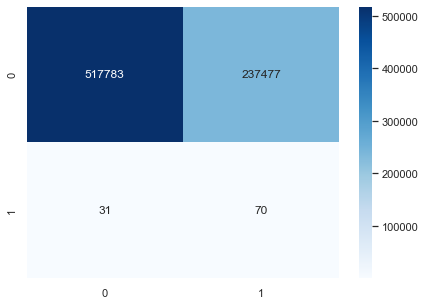

------------------------------------------------------------------------------------
LogisticRegression cluster2_4

              precision    recall  f1-score   support

       False       1.00      0.64      0.78    414065
        True       0.00      0.66      0.00       128

    accuracy                           0.64    414193
   macro avg       0.50      0.65      0.39    414193
weighted avg       1.00      0.64      0.78    414193



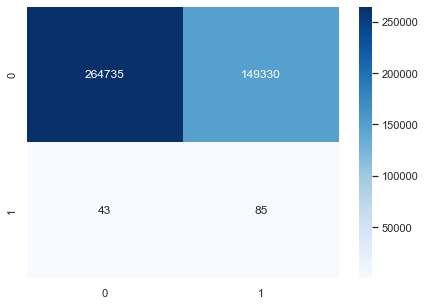

------------------------------------------------------------------------------------
LogisticRegression cluster2_5

              precision    recall  f1-score   support

       False       1.00      0.49      0.66    930360
        True       0.01      0.69      0.01      3772

    accuracy                           0.50    934132
   macro avg       0.50      0.59      0.34    934132
weighted avg       0.99      0.50      0.66    934132



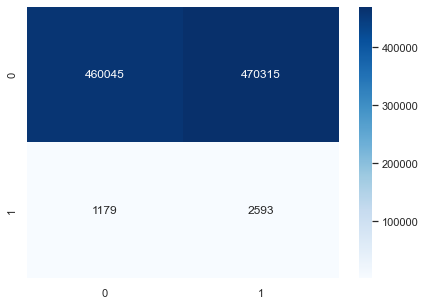

------------------------------------------------------------------------------------
LogisticRegression cluster2_6

              precision    recall  f1-score   support

       False       1.00      0.61      0.75    316993
        True       0.00      0.67      0.01       883

    accuracy                           0.61    317876
   macro avg       0.50      0.64      0.38    317876
weighted avg       1.00      0.61      0.75    317876



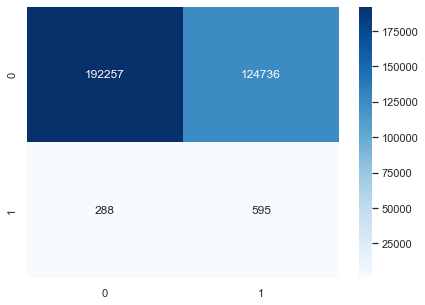

------------------------------------------------------------------------------------
LogisticRegression cluster2_7

              precision    recall  f1-score   support

       False       1.00      0.58      0.74   1722773
        True       0.01      0.65      0.01      7848

    accuracy                           0.58   1730621
   macro avg       0.50      0.62      0.38   1730621
weighted avg       0.99      0.58      0.73   1730621



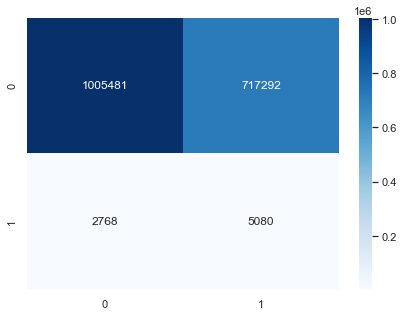

------------------------------------------------------------------------------------
LogisticRegression cluster2_8

              precision    recall  f1-score   support

       False       1.00      0.65      0.79   1215401
        True       0.00      0.73      0.01      2401

    accuracy                           0.65   1217802
   macro avg       0.50      0.69      0.40   1217802
weighted avg       1.00      0.65      0.79   1217802



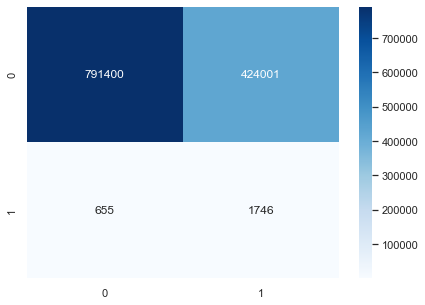

------------------------------------------------------------------------------------
LogisticRegression cluster2_9

              precision    recall  f1-score   support

       False       1.00      0.65      0.79    555328
        True       0.00      0.70      0.00       441

    accuracy                           0.65    555769
   macro avg       0.50      0.67      0.40    555769
weighted avg       1.00      0.65      0.79    555769



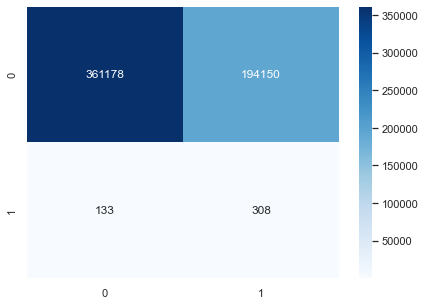

------------------------------------------------------------------------------------
DecisionTreeClassifier All

              precision    recall  f1-score   support

       False       1.00      0.65      0.79   8806490
        True       0.00      0.64      0.01     21229

    accuracy                           0.65   8827719
   macro avg       0.50      0.65      0.40   8827719
weighted avg       1.00      0.65      0.79   8827719



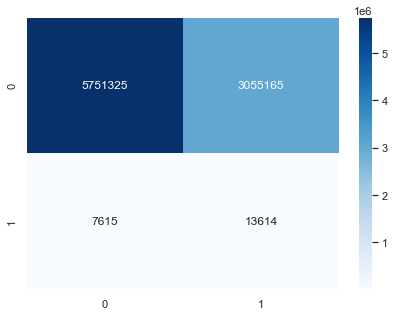

------------------------------------------------------------------------------------
DecisionTreeClassifier Adult_Standard

              precision    recall  f1-score   support

       False       0.99      0.65      0.79    205182
        True       0.03      0.64      0.06      3678

    accuracy                           0.65    208860
   macro avg       0.51      0.65      0.42    208860
weighted avg       0.97      0.65      0.77    208860



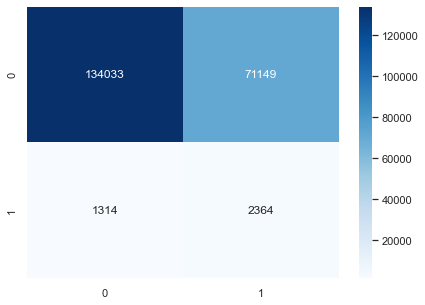

------------------------------------------------------------------------------------
DecisionTreeClassifier Rock

              precision    recall  f1-score   support

       False       0.99      0.60      0.75    650866
        True       0.01      0.61      0.03      6311

    accuracy                           0.60    657177
   macro avg       0.50      0.61      0.39    657177
weighted avg       0.98      0.60      0.74    657177



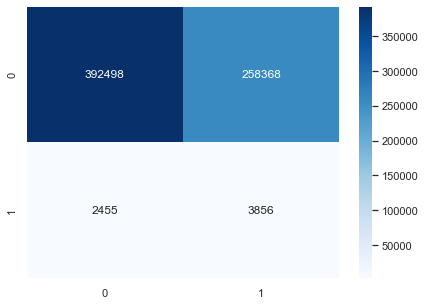

------------------------------------------------------------------------------------
DecisionTreeClassifier R&B

              precision    recall  f1-score   support

       False       0.99      0.60      0.75    133613
        True       0.03      0.60      0.06      2965

    accuracy                           0.60    136578
   macro avg       0.51      0.60      0.41    136578
weighted avg       0.96      0.60      0.73    136578



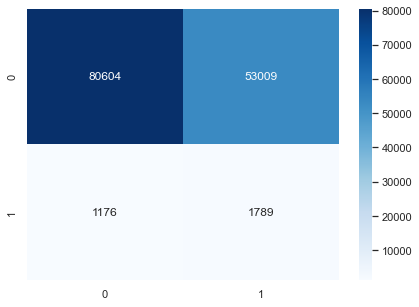

------------------------------------------------------------------------------------
DecisionTreeClassifier Country

              precision    recall  f1-score   support

       False       0.99      0.63      0.77    267768
        True       0.02      0.63      0.03      2448

    accuracy                           0.63    270216
   macro avg       0.50      0.63      0.40    270216
weighted avg       0.99      0.63      0.76    270216



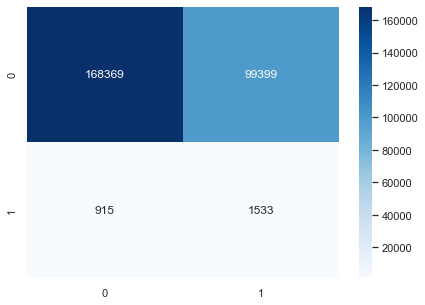

------------------------------------------------------------------------------------
DecisionTreeClassifier Pop

              precision    recall  f1-score   support

       False       0.99      0.57      0.73    536222
        True       0.01      0.59      0.02      3904

    accuracy                           0.57    540126
   macro avg       0.50      0.58      0.37    540126
weighted avg       0.99      0.57      0.72    540126



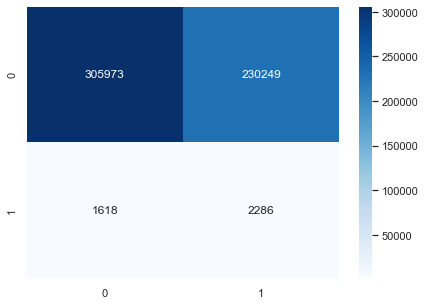

------------------------------------------------------------------------------------
DecisionTreeClassifier Rap

              precision    recall  f1-score   support

       False       1.00      0.57      0.73    413914
        True       0.01      0.57      0.01      2084

    accuracy                           0.57    415998
   macro avg       0.50      0.57      0.37    415998
weighted avg       0.99      0.57      0.73    415998



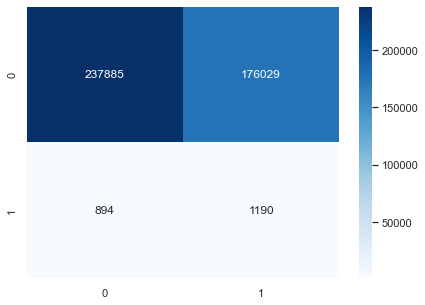

------------------------------------------------------------------------------------
DecisionTreeClassifier Alternative

              precision    recall  f1-score   support

       False       1.00      0.64      0.78     84773
        True       0.00      0.72      0.01       177

    accuracy                           0.64     84950
   macro avg       0.50      0.68      0.39     84950
weighted avg       1.00      0.64      0.77     84950



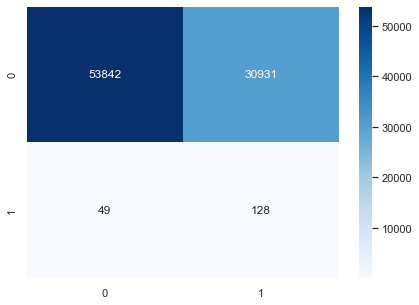

------------------------------------------------------------------------------------
DecisionTreeClassifier EDM

              precision    recall  f1-score   support

       False       1.00      0.70      0.83    249494
        True       0.00      0.68      0.00       103

    accuracy                           0.70    249597
   macro avg       0.50      0.69      0.41    249597
weighted avg       1.00      0.70      0.83    249597



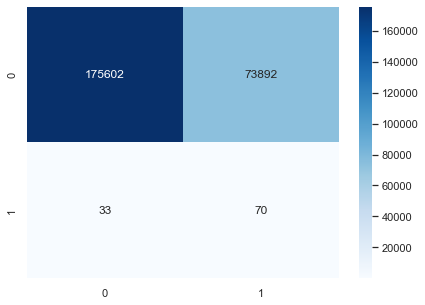

------------------------------------------------------------------------------------
DecisionTreeClassifier Metal

              precision    recall  f1-score   support

       False       1.00      0.75      0.86    245257
        True       0.00      0.75      0.00       142

    accuracy                           0.75    245399
   macro avg       0.50      0.75      0.43    245399
weighted avg       1.00      0.75      0.86    245399



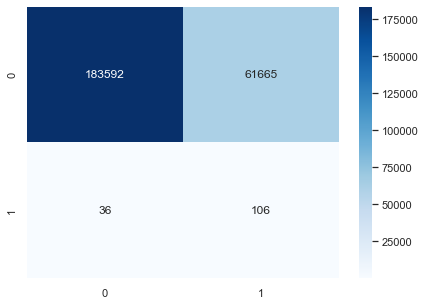

------------------------------------------------------------------------------------
DecisionTreeClassifier cluster1_0

              precision    recall  f1-score   support

       False       1.00      0.70      0.82   1233434
        True       0.00      0.72      0.00       184

    accuracy                           0.70   1233618
   macro avg       0.50      0.71      0.41   1233618
weighted avg       1.00      0.70      0.82   1233618



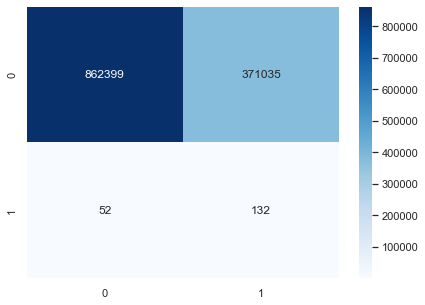

------------------------------------------------------------------------------------
DecisionTreeClassifier cluster1_1

              precision    recall  f1-score   support

       False       1.00      0.58      0.73   3963531
        True       0.01      0.58      0.01     14659

    accuracy                           0.58   3978190
   macro avg       0.50      0.58      0.37   3978190
weighted avg       0.99      0.58      0.73   3978190



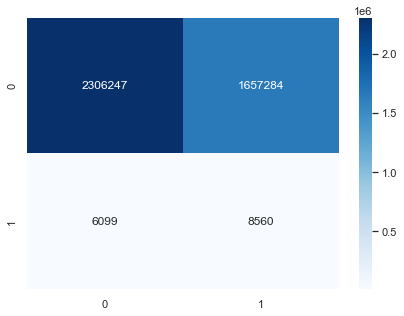

------------------------------------------------------------------------------------
DecisionTreeClassifier cluster1_2

              precision    recall  f1-score   support

       False       1.00      0.64      0.78   2298937
        True       0.00      0.64      0.01      5844

    accuracy                           0.64   2304781
   macro avg       0.50      0.64      0.39   2304781
weighted avg       1.00      0.64      0.78   2304781



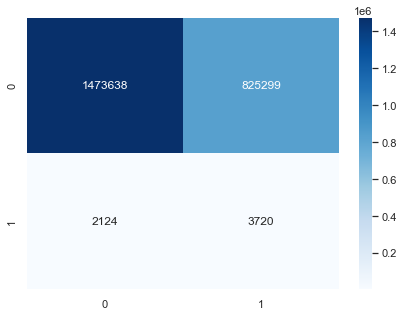

------------------------------------------------------------------------------------
DecisionTreeClassifier cluster1_3

              precision    recall  f1-score   support

       False       1.00      0.66      0.80   1310588
        True       0.00      0.67      0.00       542

    accuracy                           0.66   1311130
   macro avg       0.50      0.66      0.40   1311130
weighted avg       1.00      0.66      0.79   1311130



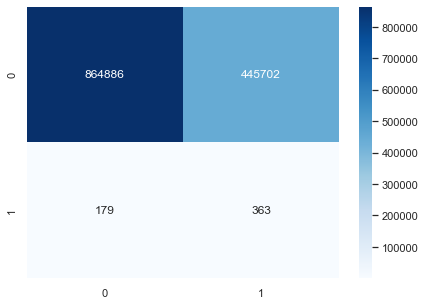

------------------------------------------------------------------------------------
DecisionTreeClassifier cluster2_0

              precision    recall  f1-score   support

       False       1.00      0.61      0.76    993405
        True       0.00      0.62      0.01      2156

    accuracy                           0.61    995561
   macro avg       0.50      0.62      0.38    995561
weighted avg       1.00      0.61      0.76    995561



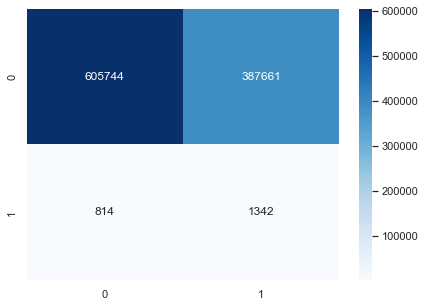

------------------------------------------------------------------------------------
DecisionTreeClassifier cluster2_1

              precision    recall  f1-score   support

       False       1.00      0.63      0.77   1083536
        True       0.01      0.62      0.01      3443

    accuracy                           0.63   1086979
   macro avg       0.50      0.63      0.39   1086979
weighted avg       0.99      0.63      0.77   1086979



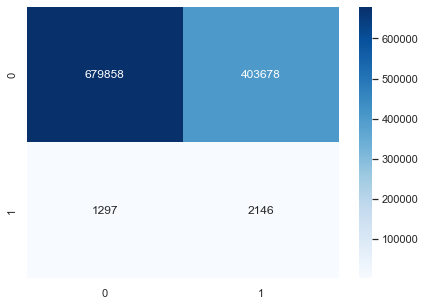

------------------------------------------------------------------------------------
DecisionTreeClassifier cluster2_2

              precision    recall  f1-score   support

       False       1.00      0.69      0.81    819369
        True       0.00      0.64      0.00        56

    accuracy                           0.69    819425
   macro avg       0.50      0.66      0.41    819425
weighted avg       1.00      0.69      0.81    819425



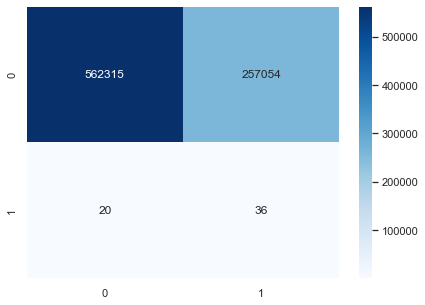

------------------------------------------------------------------------------------
DecisionTreeClassifier cluster2_3

              precision    recall  f1-score   support

       False       1.00      0.63      0.77    755260
        True       0.00      0.66      0.00       101

    accuracy                           0.63    755361
   macro avg       0.50      0.64      0.39    755361
weighted avg       1.00      0.63      0.77    755361



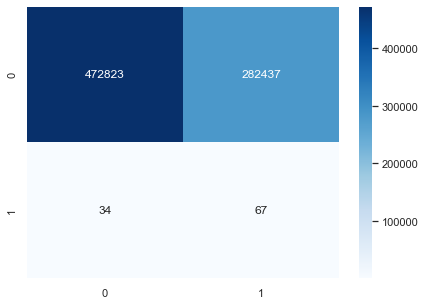

------------------------------------------------------------------------------------
DecisionTreeClassifier cluster2_4

              precision    recall  f1-score   support

       False       1.00      0.64      0.78    414065
        True       0.00      0.69      0.00       128

    accuracy                           0.64    414193
   macro avg       0.50      0.67      0.39    414193
weighted avg       1.00      0.64      0.78    414193



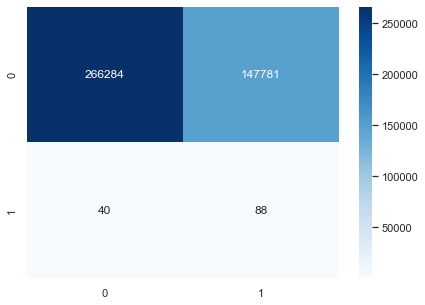

------------------------------------------------------------------------------------
DecisionTreeClassifier cluster2_5

              precision    recall  f1-score   support

       False       1.00      0.57      0.72    930360
        True       0.01      0.56      0.01      3772

    accuracy                           0.57    934132
   macro avg       0.50      0.56      0.37    934132
weighted avg       0.99      0.57      0.72    934132



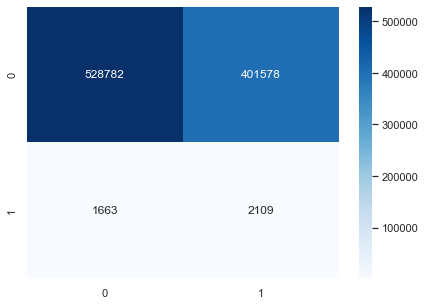

------------------------------------------------------------------------------------
DecisionTreeClassifier cluster2_6

              precision    recall  f1-score   support

       False       1.00      0.58      0.73    316993
        True       0.00      0.59      0.01       883

    accuracy                           0.58    317876
   macro avg       0.50      0.59      0.37    317876
weighted avg       1.00      0.58      0.73    317876



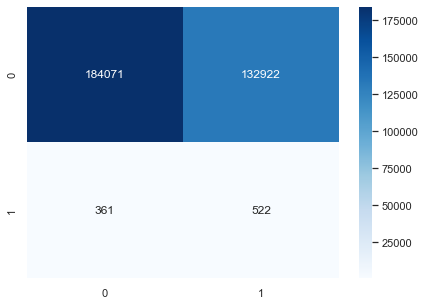

------------------------------------------------------------------------------------
DecisionTreeClassifier cluster2_7

              precision    recall  f1-score   support

       False       1.00      0.57      0.73   1722773
        True       0.01      0.58      0.01      7848

    accuracy                           0.57   1730621
   macro avg       0.50      0.57      0.37   1730621
weighted avg       0.99      0.57      0.72   1730621



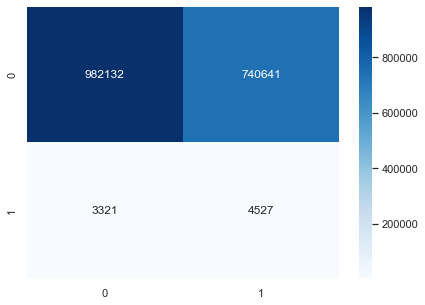

------------------------------------------------------------------------------------
DecisionTreeClassifier cluster2_8

              precision    recall  f1-score   support

       False       1.00      0.63      0.77   1215401
        True       0.00      0.64      0.01      2401

    accuracy                           0.63   1217802
   macro avg       0.50      0.64      0.39   1217802
weighted avg       1.00      0.63      0.77   1217802



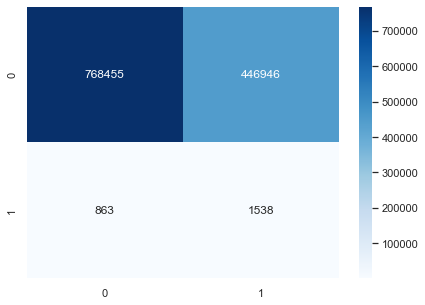

------------------------------------------------------------------------------------
DecisionTreeClassifier cluster2_9

              precision    recall  f1-score   support

       False       1.00      0.61      0.76    555328
        True       0.00      0.61      0.00       441

    accuracy                           0.61    555769
   macro avg       0.50      0.61      0.38    555769
weighted avg       1.00      0.61      0.76    555769



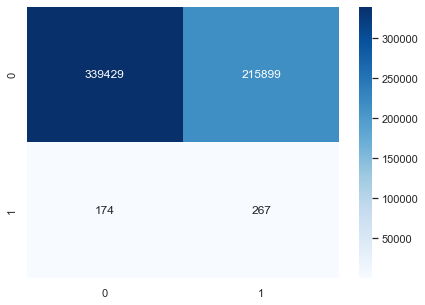

------------------------------------------------------------------------------------
RandomForestClassifier All

              precision    recall  f1-score   support

       False       1.00      0.67      0.81   8806490
        True       0.01      0.80      0.01     21229

    accuracy                           0.67   8827719
   macro avg       0.50      0.74      0.41   8827719
weighted avg       1.00      0.67      0.80   8827719



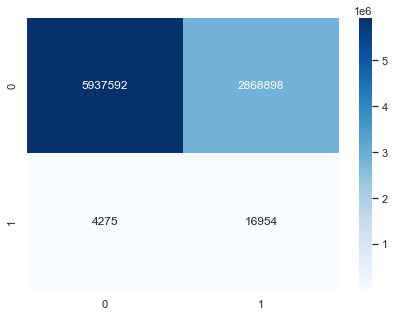

------------------------------------------------------------------------------------
RandomForestClassifier Adult_Standard

              precision    recall  f1-score   support

       False       0.99      0.68      0.81    205182
        True       0.04      0.80      0.08      3678

    accuracy                           0.68    208860
   macro avg       0.52      0.74      0.44    208860
weighted avg       0.98      0.68      0.79    208860



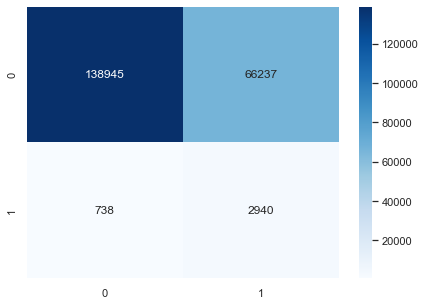

------------------------------------------------------------------------------------
RandomForestClassifier Rock

              precision    recall  f1-score   support

       False       1.00      0.66      0.80    650866
        True       0.02      0.72      0.04      6311

    accuracy                           0.66    657177
   macro avg       0.51      0.69      0.42    657177
weighted avg       0.99      0.66      0.79    657177



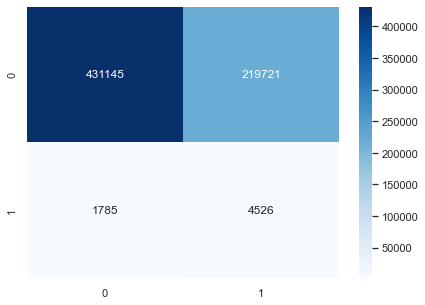

------------------------------------------------------------------------------------
RandomForestClassifier R&B

              precision    recall  f1-score   support

       False       0.99      0.65      0.79    133613
        True       0.04      0.71      0.08      2965

    accuracy                           0.66    136578
   macro avg       0.52      0.68      0.44    136578
weighted avg       0.97      0.66      0.77    136578



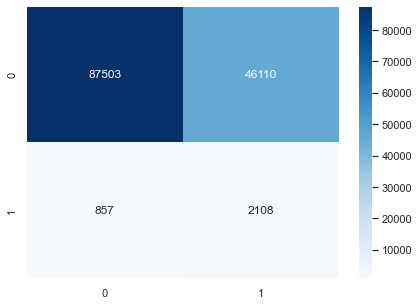

------------------------------------------------------------------------------------
RandomForestClassifier Country

              precision    recall  f1-score   support

       False       1.00      0.70      0.82    267768
        True       0.02      0.72      0.04      2448

    accuracy                           0.70    270216
   macro avg       0.51      0.71      0.43    270216
weighted avg       0.99      0.70      0.82    270216



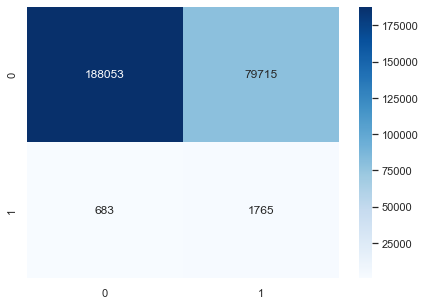

------------------------------------------------------------------------------------
RandomForestClassifier Pop

              precision    recall  f1-score   support

       False       1.00      0.65      0.78    536222
        True       0.01      0.65      0.03      3904

    accuracy                           0.65    540126
   macro avg       0.50      0.65      0.40    540126
weighted avg       0.99      0.65      0.78    540126



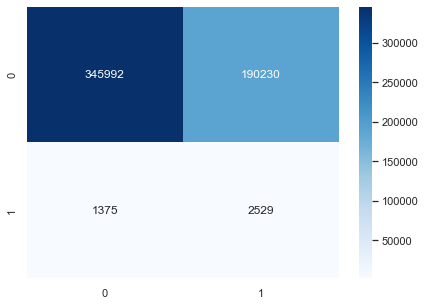

------------------------------------------------------------------------------------
RandomForestClassifier Rap

              precision    recall  f1-score   support

       False       1.00      0.65      0.79    413914
        True       0.01      0.65      0.02      2084

    accuracy                           0.65    415998
   macro avg       0.50      0.65      0.40    415998
weighted avg       0.99      0.65      0.79    415998



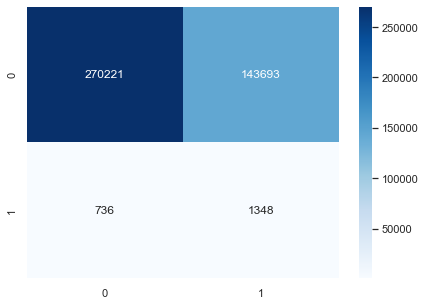

------------------------------------------------------------------------------------
RandomForestClassifier Alternative

              precision    recall  f1-score   support

       False       1.00      0.77      0.87     84773
        True       0.01      0.71      0.01       177

    accuracy                           0.77     84950
   macro avg       0.50      0.74      0.44     84950
weighted avg       1.00      0.77      0.87     84950



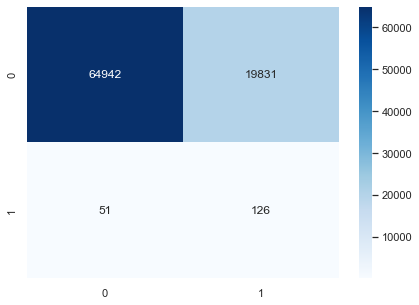

------------------------------------------------------------------------------------
RandomForestClassifier EDM

              precision    recall  f1-score   support

       False       1.00      0.81      0.89    249494
        True       0.00      0.81      0.00       103

    accuracy                           0.81    249597
   macro avg       0.50      0.81      0.45    249597
weighted avg       1.00      0.81      0.89    249597



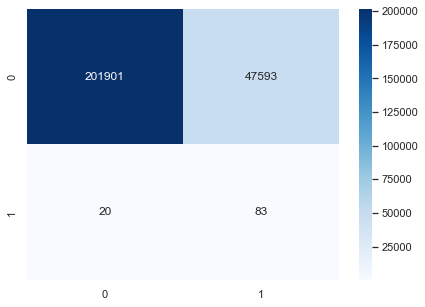

------------------------------------------------------------------------------------
RandomForestClassifier Metal

              precision    recall  f1-score   support

       False       1.00      0.82      0.90    245257
        True       0.00      0.83      0.01       142

    accuracy                           0.82    245399
   macro avg       0.50      0.82      0.45    245399
weighted avg       1.00      0.82      0.90    245399



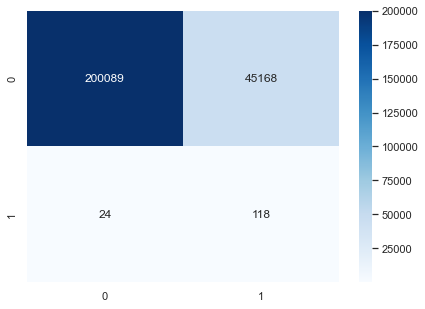

------------------------------------------------------------------------------------
RandomForestClassifier cluster1_0

              precision    recall  f1-score   support

       False       1.00      0.76      0.86   1233434
        True       0.00      0.78      0.00       184

    accuracy                           0.76   1233618
   macro avg       0.50      0.77      0.43   1233618
weighted avg       1.00      0.76      0.86   1233618



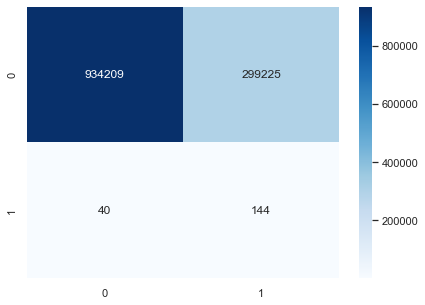

------------------------------------------------------------------------------------
RandomForestClassifier cluster1_1

              precision    recall  f1-score   support

       False       1.00      0.66      0.79   3963531
        True       0.01      0.68      0.01     14659

    accuracy                           0.66   3978190
   macro avg       0.50      0.67      0.40   3978190
weighted avg       0.99      0.66      0.79   3978190



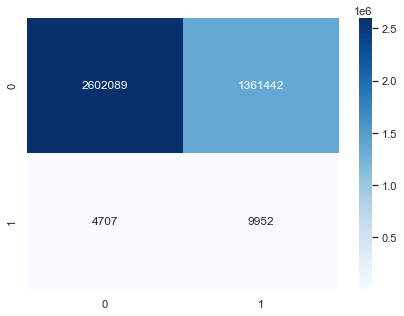

------------------------------------------------------------------------------------
RandomForestClassifier cluster1_2

              precision    recall  f1-score   support

       False       1.00      0.71      0.83   2298937
        True       0.01      0.74      0.01      5844

    accuracy                           0.71   2304781
   macro avg       0.50      0.73      0.42   2304781
weighted avg       1.00      0.71      0.83   2304781



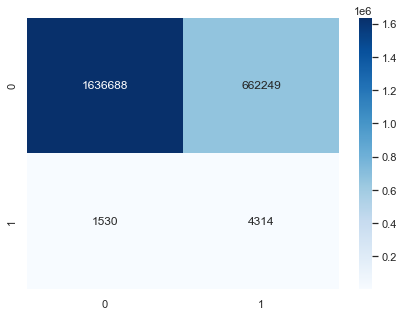

------------------------------------------------------------------------------------
RandomForestClassifier cluster1_3

              precision    recall  f1-score   support

       False       1.00      0.74      0.85   1310588
        True       0.00      0.76      0.00       542

    accuracy                           0.74   1311130
   macro avg       0.50      0.75      0.42   1311130
weighted avg       1.00      0.74      0.85   1311130



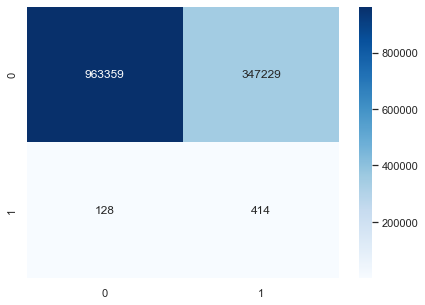

------------------------------------------------------------------------------------
RandomForestClassifier cluster2_0

              precision    recall  f1-score   support

       False       1.00      0.68      0.81    993405
        True       0.00      0.70      0.01      2156

    accuracy                           0.68    995561
   macro avg       0.50      0.69      0.41    995561
weighted avg       1.00      0.68      0.81    995561



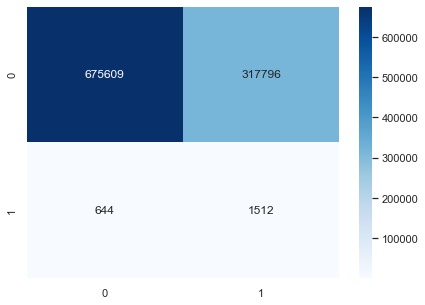

------------------------------------------------------------------------------------
RandomForestClassifier cluster2_1

              precision    recall  f1-score   support

       False       1.00      0.72      0.83   1083536
        True       0.01      0.71      0.02      3443

    accuracy                           0.72   1086979
   macro avg       0.50      0.71      0.43   1086979
weighted avg       1.00      0.72      0.83   1086979



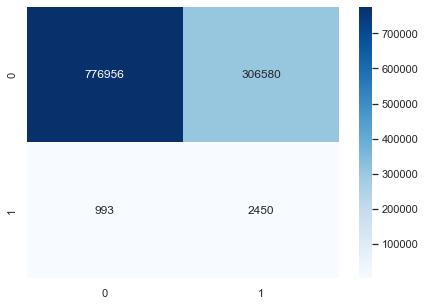

------------------------------------------------------------------------------------
RandomForestClassifier cluster2_2

              precision    recall  f1-score   support

       False       1.00      0.78      0.88    819369
        True       0.00      0.71      0.00        56

    accuracy                           0.78    819425
   macro avg       0.50      0.75      0.44    819425
weighted avg       1.00      0.78      0.88    819425



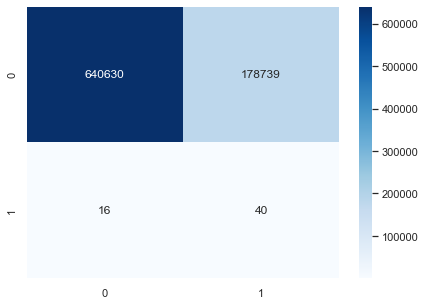

------------------------------------------------------------------------------------
RandomForestClassifier cluster2_3

              precision    recall  f1-score   support

       False       1.00      0.72      0.84    755260
        True       0.00      0.66      0.00       101

    accuracy                           0.72    755361
   macro avg       0.50      0.69      0.42    755361
weighted avg       1.00      0.72      0.84    755361



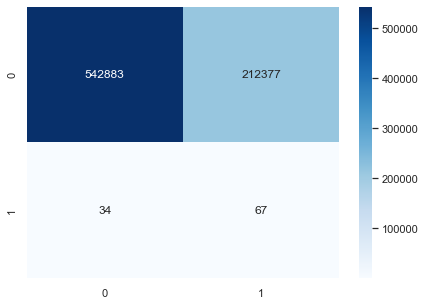

------------------------------------------------------------------------------------
RandomForestClassifier cluster2_4

              precision    recall  f1-score   support

       False       1.00      0.72      0.83    414065
        True       0.00      0.67      0.00       128

    accuracy                           0.72    414193
   macro avg       0.50      0.69      0.42    414193
weighted avg       1.00      0.72      0.83    414193



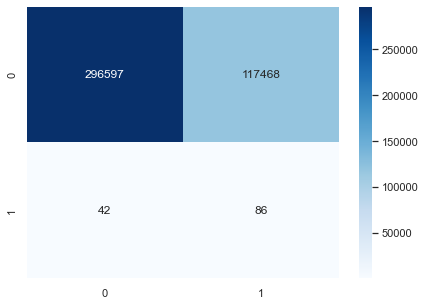

------------------------------------------------------------------------------------
RandomForestClassifier cluster2_5

              precision    recall  f1-score   support

       False       1.00      0.62      0.77    930360
        True       0.01      0.64      0.01      3772

    accuracy                           0.62    934132
   macro avg       0.50      0.63      0.39    934132
weighted avg       0.99      0.62      0.76    934132



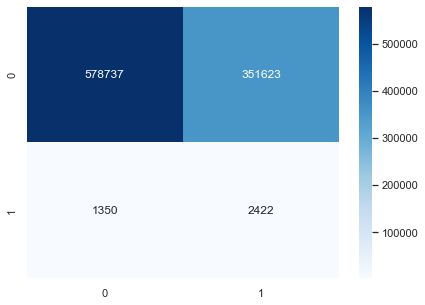

------------------------------------------------------------------------------------
RandomForestClassifier cluster2_6

              precision    recall  f1-score   support

       False       1.00      0.68      0.81    316993
        True       0.01      0.65      0.01       883

    accuracy                           0.68    317876
   macro avg       0.50      0.67      0.41    317876
weighted avg       1.00      0.68      0.81    317876



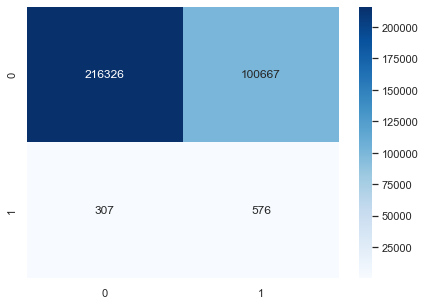

------------------------------------------------------------------------------------
RandomForestClassifier cluster2_7

              precision    recall  f1-score   support

       False       1.00      0.68      0.81   1722773
        True       0.01      0.64      0.02      7848

    accuracy                           0.68   1730621
   macro avg       0.50      0.66      0.41   1730621
weighted avg       0.99      0.68      0.80   1730621



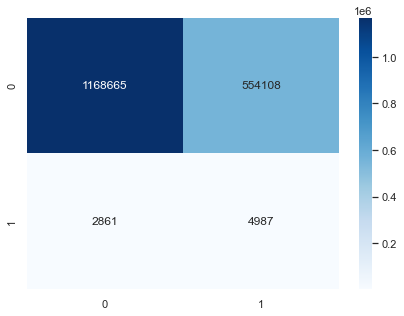

------------------------------------------------------------------------------------
RandomForestClassifier cluster2_8

              precision    recall  f1-score   support

       False       1.00      0.70      0.82   1215401
        True       0.00      0.75      0.01      2401

    accuracy                           0.70   1217802
   macro avg       0.50      0.72      0.42   1217802
weighted avg       1.00      0.70      0.82   1217802



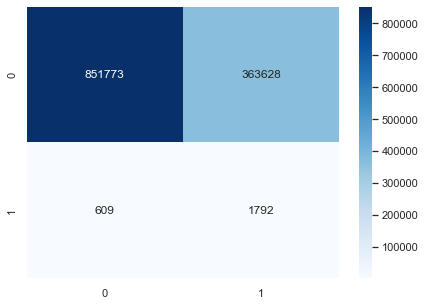

------------------------------------------------------------------------------------
RandomForestClassifier cluster2_9

              precision    recall  f1-score   support

       False       1.00      0.70      0.83    555328
        True       0.00      0.67      0.00       441

    accuracy                           0.70    555769
   macro avg       0.50      0.69      0.41    555769
weighted avg       1.00      0.70      0.83    555769



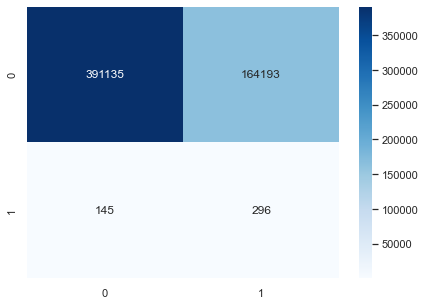

------------------------------------------------------------------------------------
AdaBoostClassifier All

              precision    recall  f1-score   support

       False       1.00      0.60      0.75   8806490
        True       0.00      0.80      0.01     21229

    accuracy                           0.60   8827719
   macro avg       0.50      0.70      0.38   8827719
weighted avg       1.00      0.60      0.75   8827719



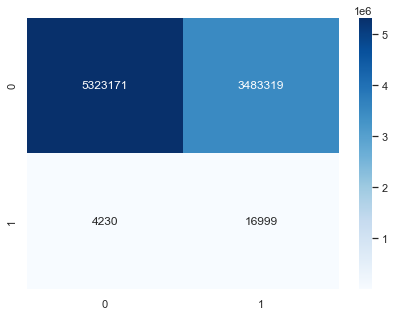

------------------------------------------------------------------------------------
AdaBoostClassifier Adult_Standard

              precision    recall  f1-score   support

       False       0.99      0.66      0.79    205182
        True       0.04      0.79      0.08      3678

    accuracy                           0.66    208860
   macro avg       0.52      0.72      0.43    208860
weighted avg       0.98      0.66      0.78    208860



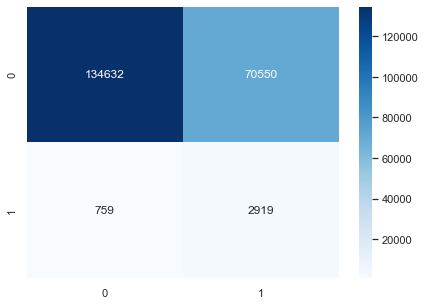

------------------------------------------------------------------------------------
AdaBoostClassifier Rock

              precision    recall  f1-score   support

       False       1.00      0.61      0.76    650866
        True       0.02      0.75      0.04      6311

    accuracy                           0.61    657177
   macro avg       0.51      0.68      0.40    657177
weighted avg       0.99      0.61      0.75    657177



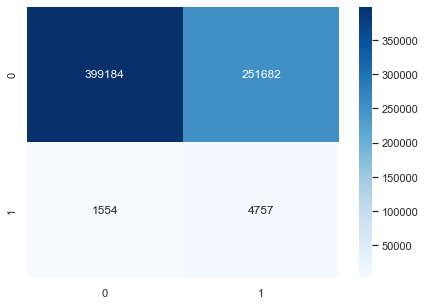

------------------------------------------------------------------------------------
AdaBoostClassifier R&B

              precision    recall  f1-score   support

       False       0.99      0.62      0.76    133613
        True       0.04      0.72      0.08      2965

    accuracy                           0.62    136578
   macro avg       0.52      0.67      0.42    136578
weighted avg       0.97      0.62      0.74    136578



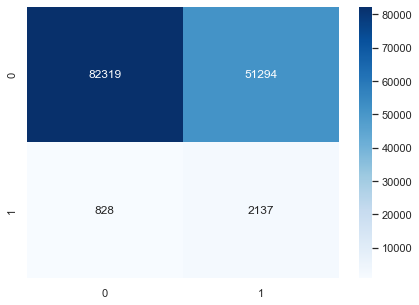

------------------------------------------------------------------------------------
AdaBoostClassifier Country

              precision    recall  f1-score   support

       False       1.00      0.66      0.79    267768
        True       0.02      0.75      0.04      2448

    accuracy                           0.66    270216
   macro avg       0.51      0.71      0.41    270216
weighted avg       0.99      0.66      0.78    270216



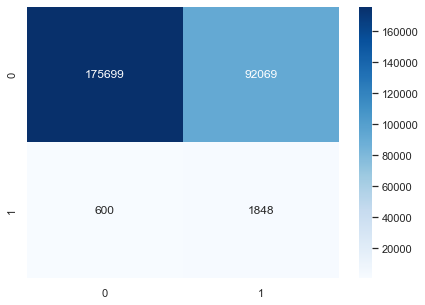

------------------------------------------------------------------------------------
AdaBoostClassifier Pop

              precision    recall  f1-score   support

       False       1.00      0.54      0.70    536222
        True       0.01      0.70      0.02      3904

    accuracy                           0.54    540126
   macro avg       0.50      0.62      0.36    540126
weighted avg       0.99      0.54      0.70    540126



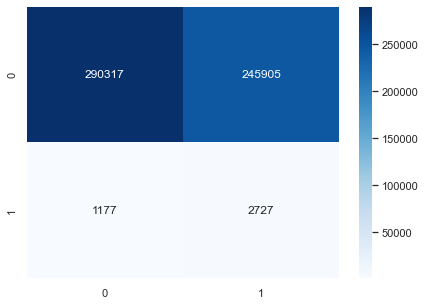

------------------------------------------------------------------------------------
AdaBoostClassifier Rap

              precision    recall  f1-score   support

       False       1.00      0.62      0.77    413914
        True       0.01      0.64      0.02      2084

    accuracy                           0.62    415998
   macro avg       0.50      0.63      0.39    415998
weighted avg       0.99      0.62      0.76    415998



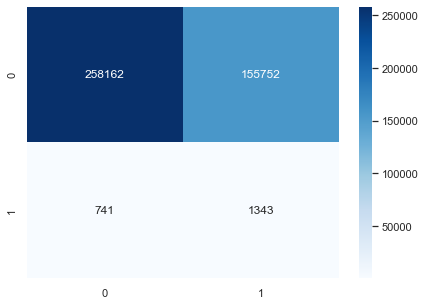

------------------------------------------------------------------------------------
AdaBoostClassifier Alternative

              precision    recall  f1-score   support

       False       1.00      0.67      0.80     84773
        True       0.00      0.76      0.01       177

    accuracy                           0.67     84950
   macro avg       0.50      0.71      0.40     84950
weighted avg       1.00      0.67      0.80     84950



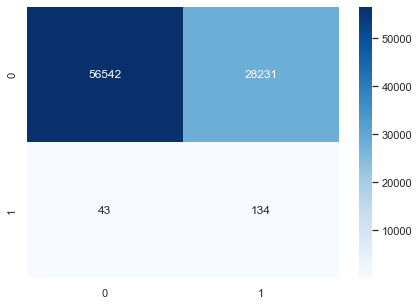

------------------------------------------------------------------------------------
AdaBoostClassifier EDM

              precision    recall  f1-score   support

       False       1.00      0.75      0.86    249494
        True       0.00      0.74      0.00       103

    accuracy                           0.75    249597
   macro avg       0.50      0.74      0.43    249597
weighted avg       1.00      0.75      0.86    249597



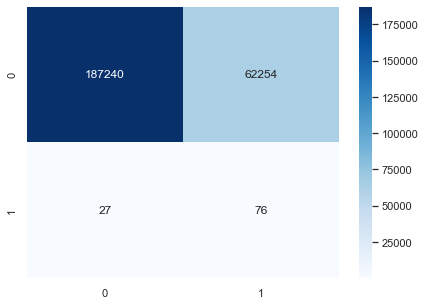

------------------------------------------------------------------------------------
AdaBoostClassifier Metal

              precision    recall  f1-score   support

       False       1.00      0.75      0.86    245257
        True       0.00      0.77      0.00       142

    accuracy                           0.75    245399
   macro avg       0.50      0.76      0.43    245399
weighted avg       1.00      0.75      0.86    245399



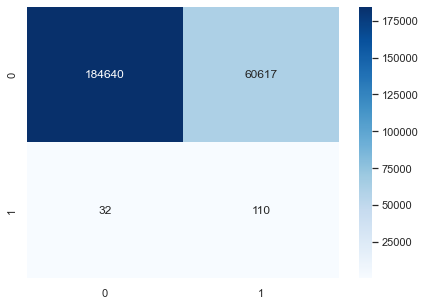

------------------------------------------------------------------------------------
AdaBoostClassifier cluster1_0

              precision    recall  f1-score   support

       False       1.00      0.74      0.85   1233434
        True       0.00      0.73      0.00       184

    accuracy                           0.74   1233618
   macro avg       0.50      0.74      0.43   1233618
weighted avg       1.00      0.74      0.85   1233618



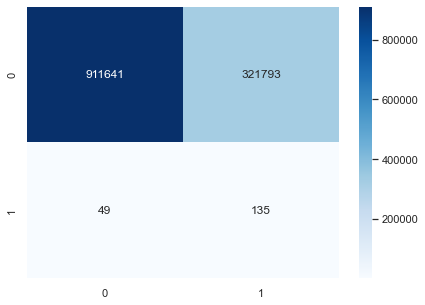

------------------------------------------------------------------------------------
AdaBoostClassifier cluster1_1

              precision    recall  f1-score   support

       False       1.00      0.57      0.73   3963531
        True       0.01      0.68      0.01     14659

    accuracy                           0.57   3978190
   macro avg       0.50      0.63      0.37   3978190
weighted avg       0.99      0.57      0.72   3978190



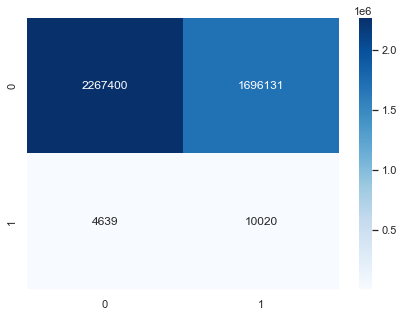

------------------------------------------------------------------------------------
AdaBoostClassifier cluster1_2

              precision    recall  f1-score   support

       False       1.00      0.65      0.79   2298937
        True       0.01      0.77      0.01      5844

    accuracy                           0.65   2304781
   macro avg       0.50      0.71      0.40   2304781
weighted avg       1.00      0.65      0.79   2304781



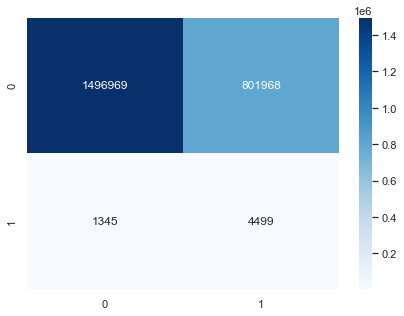

------------------------------------------------------------------------------------
AdaBoostClassifier cluster1_3

              precision    recall  f1-score   support

       False       1.00      0.71      0.83   1310588
        True       0.00      0.75      0.00       542

    accuracy                           0.71   1311130
   macro avg       0.50      0.73      0.42   1311130
weighted avg       1.00      0.71      0.83   1311130



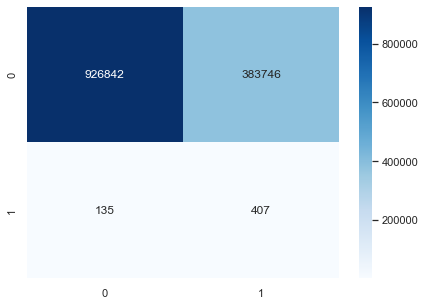

------------------------------------------------------------------------------------
AdaBoostClassifier cluster2_0

              precision    recall  f1-score   support

       False       1.00      0.64      0.78    993405
        True       0.00      0.72      0.01      2156

    accuracy                           0.64    995561
   macro avg       0.50      0.68      0.39    995561
weighted avg       1.00      0.64      0.78    995561



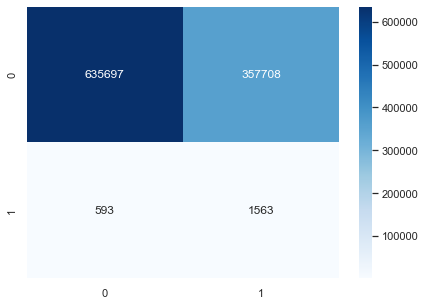

------------------------------------------------------------------------------------
AdaBoostClassifier cluster2_1

              precision    recall  f1-score   support

       False       1.00      0.66      0.79   1083536
        True       0.01      0.75      0.01      3443

    accuracy                           0.66   1086979
   macro avg       0.50      0.71      0.40   1086979
weighted avg       1.00      0.66      0.79   1086979



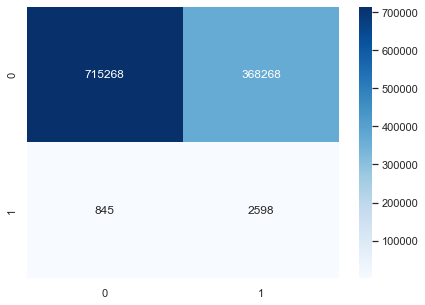

------------------------------------------------------------------------------------
AdaBoostClassifier cluster2_2

              precision    recall  f1-score   support

       False       1.00      0.70      0.83    819369
        True       0.00      0.71      0.00        56

    accuracy                           0.70    819425
   macro avg       0.50      0.71      0.41    819425
weighted avg       1.00      0.70      0.83    819425



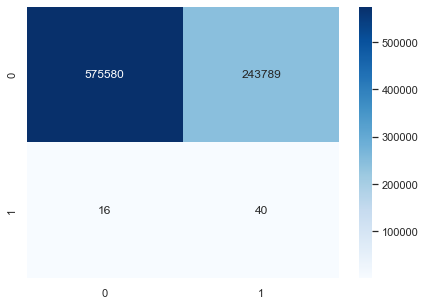

------------------------------------------------------------------------------------
AdaBoostClassifier cluster2_3

              precision    recall  f1-score   support

       False       1.00      0.62      0.76    755260
        True       0.00      0.55      0.00       101

    accuracy                           0.62    755361
   macro avg       0.50      0.59      0.38    755361
weighted avg       1.00      0.62      0.76    755361



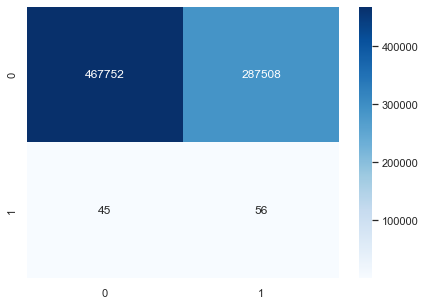

------------------------------------------------------------------------------------
AdaBoostClassifier cluster2_4

              precision    recall  f1-score   support

       False       1.00      0.69      0.82    414065
        True       0.00      0.71      0.00       128

    accuracy                           0.69    414193
   macro avg       0.50      0.70      0.41    414193
weighted avg       1.00      0.69      0.82    414193



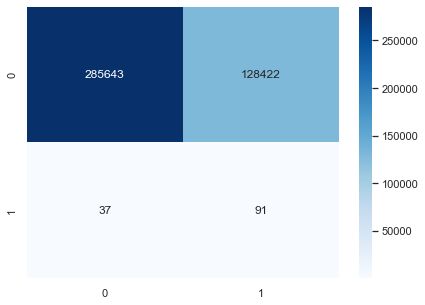

------------------------------------------------------------------------------------
AdaBoostClassifier cluster2_5

              precision    recall  f1-score   support

       False       1.00      0.55      0.71    930360
        True       0.01      0.67      0.01      3772

    accuracy                           0.55    934132
   macro avg       0.50      0.61      0.36    934132
weighted avg       0.99      0.55      0.70    934132



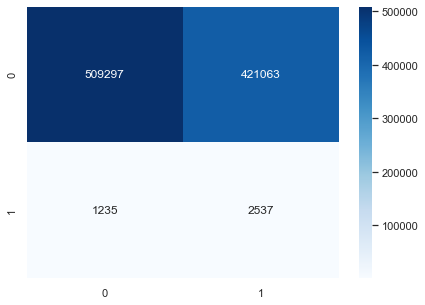

------------------------------------------------------------------------------------
AdaBoostClassifier cluster2_6

              precision    recall  f1-score   support

       False       1.00      0.58      0.73    316993
        True       0.00      0.66      0.01       883

    accuracy                           0.58    317876
   macro avg       0.50      0.62      0.37    317876
weighted avg       1.00      0.58      0.73    317876



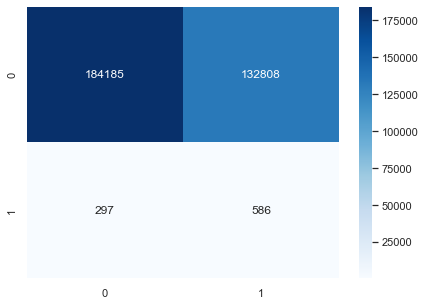

------------------------------------------------------------------------------------
AdaBoostClassifier cluster2_7

              precision    recall  f1-score   support

       False       1.00      0.61      0.76   1722773
        True       0.01      0.64      0.01      7848

    accuracy                           0.61   1730621
   macro avg       0.50      0.63      0.39   1730621
weighted avg       0.99      0.61      0.75   1730621



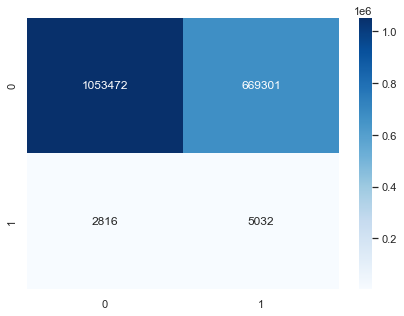

------------------------------------------------------------------------------------
AdaBoostClassifier cluster2_8

              precision    recall  f1-score   support

       False       1.00      0.66      0.80   1215401
        True       0.00      0.75      0.01      2401

    accuracy                           0.66   1217802
   macro avg       0.50      0.71      0.40   1217802
weighted avg       1.00      0.66      0.79   1217802



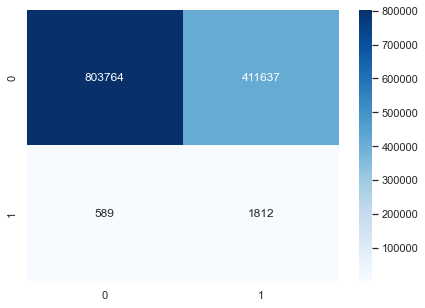

------------------------------------------------------------------------------------
AdaBoostClassifier cluster2_9

              precision    recall  f1-score   support

       False       1.00      0.66      0.79    555328
        True       0.00      0.67      0.00       441

    accuracy                           0.66    555769
   macro avg       0.50      0.67      0.40    555769
weighted avg       1.00      0.66      0.79    555769



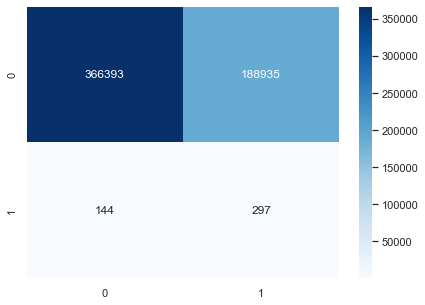

Wall time: 20min 9s


In [115]:
%%time
# save results
default_results = {}

# choose dataset and algorithm
n_cluster = 0
n_algorithm = 0

# loop through algorithms
for algorithm in ML_algorithms:
    
    model_name = str(algorithm())[:-2]
    default_results[model_name] = {}

    # loop through clusters
    for cluster_key in cluster_keys:
        
        # create working dataset
        # could loop through clusters first to save a small amount of time
        X_, y_ = clusters[cluster_key]

        # make the pipeline
        transform = RandomUnderSampler(sampling_strategy='majority')
        model = algorithm()  # logistic regression and random forest support n_jobs=-1
        pipe = make_pipeline(transform, model)

        # calculate results
        cv = StratifiedKFold(n_splits=5, shuffle=True)
        y_pred = cross_val_predict(pipe, X_, y_, cv=cv, n_jobs=-1)
        
        # print results
        print('------------------------------------------------------------------------------------')
        print(model_name, cluster_key)
        print()
        
        print(classification_report(y_, y_pred, output_dict=False))
#         plt.subplots(figsize=(7, 5))
#         sns.heatmap(confusion_matrix(y_, y_pred), cmap='Blues', annot=True, fmt='.0f')
#         plt.show()

        # save results
        """saves results as nested dict (model > cluster > (conf matrix, class report))"""
        output_conf_matrix = confusion_matrix(y_, y_pred)
        output_report = classification_report(y_, y_pred, output_dict=True)

        default_results[model_name][cluster_key] = (output_conf_matrix, output_report)

In [116]:
# check dict of results
default_results['LogisticRegression'].keys()

dict_keys(['All', 'Adult_Standard', 'Rock', 'R&B', 'Country', 'Pop', 'Rap', 'Alternative', 'EDM', 'Metal', 'cluster1_0', 'cluster1_1', 'cluster1_2', 'cluster1_3', 'cluster2_0', 'cluster2_1', 'cluster2_2', 'cluster2_3', 'cluster2_4', 'cluster2_5', 'cluster2_6', 'cluster2_7', 'cluster2_8', 'cluster2_9'])

In [117]:
default_results.keys()

dict_keys(['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier', 'AdaBoostClassifier'])

In [118]:
# save file
if True:
    with open('default_results.pickle', 'wb') as f:
        pickle.dump(default_results, f)

In [16]:
# load file
if False:
    with open('default_results.pickle', 'rb') as f:
        default_results = pickle.load(f)

In [28]:
default_results['LogisticRegression']['All'][1]['True']['f1-score']

0.008865864129889522

In [27]:
pd.DataFrame(default_results['LogisticRegression']['All'][1]).T

,precision,recall,f1-score,support
False,0.999,0.569,0.725,8806490.000
True,0.004,0.801,0.009,21229.000
accuracy,0.569,0.569,0.569,0.569
macro avg,0.502,0.685,0.367,8827719.000
weighted avg,0.997,0.569,0.723,8827719.000


In [39]:
for algo in ML_algorithms:
    algo_ = str(algo())[:-2]
    print(name_)
    for cluster in cluster_keys:
        f1_ = default_results[algo_][cluster][1]['True']['f1-score']
        print(f'{cluster}: {f1_:.3f}')

AdaBoostClassifier
All: 0.009
Adult_Standard: 0.077
Rock: 0.032
R&B: 0.071
Country: 0.038
Pop: 0.021
Rap: 0.017
Alternative: 0.009
EDM: 0.002
Metal: 0.003
cluster1_0: 0.001
cluster1_1: 0.011
cluster1_2: 0.010
cluster1_3: 0.002
cluster2_0: 0.008
cluster2_1: 0.013
cluster2_2: 0.000
cluster2_3: 0.001
cluster2_4: 0.001
cluster2_5: 0.011
cluster2_6: 0.009
cluster2_7: 0.014
cluster2_8: 0.008
cluster2_9: 0.003
AdaBoostClassifier
All: 0.009
Adult_Standard: 0.061
Rock: 0.029
R&B: 0.062
Country: 0.030
Pop: 0.019
Rap: 0.013
Alternative: 0.008
EDM: 0.002
Metal: 0.003
cluster1_0: 0.001
cluster1_1: 0.010
cluster1_2: 0.009
cluster1_3: 0.002
cluster2_0: 0.007
cluster2_1: 0.010
cluster2_2: 0.000
cluster2_3: 0.000
cluster2_4: 0.001
cluster2_5: 0.010
cluster2_6: 0.008
cluster2_7: 0.012
cluster2_8: 0.007
cluster2_9: 0.002
AdaBoostClassifier


KeyError: 'KNeighborsClassifier'

In [37]:
for cluster in cluster_keys:
    print(cluster)

All
Adult_Standard
Rock
R&B
Country
Pop
Rap
Alternative
EDM
Metal
cluster1_0
cluster1_1
cluster1_2
cluster1_3
cluster2_0
cluster2_1
cluster2_2
cluster2_3
cluster2_4
cluster2_5
cluster2_6
cluster2_7
cluster2_8
cluster2_9


# FOR LATER

In [ ]:
# for tuning hyperparameters

# parameters for gridsearch
scoring = 'recall'
param_grid = {}

# hyperparameters to tune
if n_algorithm == 0:
    # logistic regression
    param_grid['logisticregression__penalty'] = ['l1', 'l2']
elif n_algorithm == 1:
    # decision tree
    param_grid['decisiontreeclassifier__'] = ['', '']
elif n_algorithm == 2:
    # random forest
    param_grid['randomforestclassifier__'] = ['', '']
elif n_algorithm == 3:
    # adaboost boosted tree
    param_grid['adaboostclassifier__'] = ['', '']

# evaluate gridsearch
grid = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    cv = cv,
    scoring = scoring
)

# check best results

In [ ]:
# NOTE: could create holdout to validate after training 
# (alt: CV is fine)

# NOTE: recall is probably most important 
# (predict all hit songs, don't worry about false positives)

# NOTE: KNN doesn't have a predict_proba method, so it can't be used for soft voting 

# from sklearn.metrics import recall_score
# recall_score(y_true, y_pred, average='macro')
# recall_score(y_true, y_pred, average='micro')
# recall_score(y_true, y_pred, average='weighted')

# IDEA
# maybe get more precision by voting between undersampled and weighted